<a href="https://colab.research.google.com/github/gauthamhere/cycGan/blob/master/GauthamK_EIP3P2_FaceAge_utk_cycleGAN_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Downloading and installing this inorder to use keras instance normalization
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fsigy_zq
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fsigy_zq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=06b01a99eb6dac54c505044690d748fd34770fe9c167c27a0818ad45a48915f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-yuzjrw2o/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.preprocessing.image import ImageDataGenerator
import scipy
from glob import glob
import numpy as np
import os
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

from keras.models import Model
from keras.layers import Input, Conv2D

from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dropout, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.misc


class DataLoader:
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):

        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_k_data(self, domain, image_number=10, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        images = np.array(path)
        if image_number < len(path):
            images = images[:image_number]

        imgs = []
        for img_path in images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs) / 127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False, aug=False):
        data_type = "train" if not is_testing else "test"
 
        path_A = glob('%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('%s/%sB/*' % (self.dataset_name, data_type))

        if not is_testing and aug:
            datagen = ImageDataGenerator(
                zoom_range=0.2,
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                brightness_range=[0.5, 1.5]
            )

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                # Data augmenting
                if not is_testing and aug:
                    img_A = datagen.random_transform(img_A)
                    img_B = datagen.random_transform(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

Using TensorFlow backend.


In [0]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding, **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        shape = (
            input_shape[0],
            input_shape[1] + 2 * self.padding[0],
            input_shape[2] + 2 * self.padding[1],
            input_shape[3]
        )
        return shape

    def call(self, x, mask=None):
        width_pad, height_pad = self.padding
        return tf.pad(
            x,
            [[0, 0], [height_pad, height_pad], [width_pad, width_pad], [0, 0]],
            'REFLECT'
        )


nn_input = Input((128, 128, 3))
reflect_pad = ReflectionPadding2D(padding=(3, 3))(nn_input)
conv2d = Conv2D(32, kernel_size=7, strides=1, padding="valid")(reflect_pad)
model = Model(nn_input, conv2d)
model.summary()

W0818 17:18:05.581848 140216897329024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 17:18:05.598985 140216897329024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 17:18:05.606611 140216897329024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
reflection_padding2d_1 (Refl (None, 134, 134, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4736      
Total params: 4,736
Trainable params: 4,736
Non-trainable params: 0
_________________________________________________________________


## Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from shutil import copyfile
copyfile("gdrive/My Drive/face_dataset.zip","face_dataset.zip")

'face_dataset.zip'

In [0]:
!unzip -q face_dataset.zip

In [0]:
!mv face_dataset/train_young face_dataset/trainA
!mv face_dataset/train_old face_dataset/trainB
!mv face_dataset/test_young face_dataset/testA
!mv face_dataset/test_old face_dataset/testB

In [0]:
!pip install scipy==1.1.0

In [0]:
!mkdir models
!mkdir images
!mkdir test_images
!mkdir images/face_dataset_paper

## Training till 70 Epochs

In [0]:
class CycleGAN:
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'face_dataset'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2 ** 4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0  # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle  # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # -------------------------
        # Construct Computational
        #   Graph of Generators
        # -------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

        self.current_epoch = 0

    def build_generator(self):
        def conv2d(layer_input, filters, f_size=4, stride=2, padding='valid'):
            d = Conv2D(filters, kernel_size=f_size, strides=stride, padding=padding)(layer_input)
            d = InstanceNormalization()(d)
            d = Activation('relu')(d)
            return d

        def res_block(layer_input, filters=256, use_dropout=False):
            y = ReflectionPadding2D(padding=(1, 1))(layer_input)
            y = conv2d(y, filters, 3, 1)
            if use_dropout:
                y = Dropout(0.5)(y)
            y = ReflectionPadding2D(padding=(1, 1))(y)
            y = conv2d(y, filters, 3, 1)
            return Add()([y, layer_input])

        def deconv2d(layer_input, filters, f_size=4, dropout_rate=0):
            u = Conv2DTranspose(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Activation('relu')(u)
            return u

        # Image input
        d0 = Input(shape=self.img_shape)
        d1 = ReflectionPadding2D(padding=(3, 3))(d0)
        # c7s1-64
        d1 = conv2d(d1, self.gf, 7, 1)
        # d128
        d2 = conv2d(d1, self.gf * 2, 3, padding='same')
        # d256
        d3 = conv2d(d2, self.gf * 4, 3, padding='same')
        # R256,R256,R256,R256,R256,R256
        r = res_block(d3)
        r = res_block(r)
        r = res_block(r)
        r = res_block(r)
        r = res_block(r)
        r = res_block(r)
        # u128
        u1 = deconv2d(r, self.gf * 2, 3)
        # u64
        u2 = deconv2d(u1, self.gf, 3)
        # c7s1-3
        u3 = ReflectionPadding2D(padding=(3, 3))(u2)
        output_img = Conv2D(self.channels, kernel_size=7, strides=1, activation='tanh')(u3)

        return Model(d0, output_img)

    def build_discriminator(self):
        def d_layer(layer_input, filters, f_size=4, normalization=True):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            if normalization:
                d = InstanceNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        img = Input(shape=self.img_shape)
        # C64-C128-C256-C512
        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df * 2)
        d3 = d_layer(d2, self.df * 4)
        d4 = d_layer(d3, self.df * 8)
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def load_network(self, n_epoch_start,path):
        # returns a compiled model identical to the previous one
        self.current_epoch = n_epoch_start+1
        self.combined.load_weights(path)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()
        print(start_time)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size, aug=True)):
                # ----------------------
                #  Train Discriminators
                # ----------------------
                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                    % (epoch, epochs,
                       batch_i, self.data_loader.n_batches,
                       d_loss[0], 100 * d_loss[1],
                       g_loss[0],
                       np.mean(g_loss[1:3]),
                       np.mean(g_loss[3:5]),
                       np.mean(g_loss[5:6]),
                       elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch+self.current_epoch, batch_i)

            if epoch % 10 == 0 and (epoch != 0 or self.current_epoch != 0):
                self.combined.save("models/combined_ep{}.h5".format(
                    self.dataset_name,
                    epoch+self.current_epoch)
                )
                self.combined.save(path+"models/combined_ep_{}.h5".format(
                    epoch+self.current_epoch)
                )

    def sample_images(self, epoch, batch_i):
        r, c = 2, 3
        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i, j].axis('off')
                cnt += 1

        fig.savefig("images/{}_paper/{}_{}.png".format(
            self.dataset_name, epoch, batch_i))
        fig.savefig(path+"images/{}_paper/{}_{}.png".format(
            self.dataset_name, epoch, batch_i))
        plt.close()

    def test_k_images(self, im_path="1.jpg",translated_path="t.jpg",output_path="o.jpg"):
        r, c = 1, 3
        
        img_res=(128, 128)

        
        imgs_A = scipy.misc.imread(im_path)
        imgs_A = scipy.misc.imresize(imgs_A, img_res)
        imgs_A = np.array(imgs_A)/127.5 - 1.
        
        
        imgs_A = np.expand_dims(imgs_A,axis=0)
        
        
        

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
#         fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
#         reconstr_B = self.g_AB.predict(fake_A)

        for image_i in range(len(imgs_A)):
            gen_imgs = np.concatenate([
                np.expand_dims(imgs_A[image_i], axis=0),
                np.expand_dims(fake_B[image_i], axis=0),
                np.expand_dims(reconstr_A[image_i], axis=0),
#                 np.expand_dims(imgs_B[image_i], axis=0),
#                 np.expand_dims(fake_A[image_i], axis=0),
#                 np.expand_dims(reconstr_B[image_i], axis=0)
            ])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
          
            translated_img = gen_imgs[1]
            scipy.misc.imsave(translated_path, translated_img)
             
          
          
          
            fig, axs = plt.subplots(1, 3, figsize=(10, 3))
            cnt = 0
            for ax, title_im in zip(axs, ['original', 'translated', 'reconstructed']):
              ax.imshow(gen_imgs[cnt])
              ax.axis('off')
              ax.set_title(title_im.capitalize())
              ax.grid(True)
              cnt+=1
              
            fig.savefig(output_path)
            plt.show()
            plt.close()

## Training till 70 epochs ~ 12 hours 

In [0]:
cyclegan = CycleGAN()
cyclegan.train(epochs=150, batch_size=16, sample_interval=200 , path = "gdrive/My Drive/face/")

2019-08-04 23:38:48.941092


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/

[Epoch 0/150] [Batch 0/240] [D loss: 20.289265, acc:  10%] [G loss: 42.676563, adv: 13.858452, recon: 0.682087, id: 0.580758] time: 0:01:07.107414 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weigh

[Epoch 0/150] [Batch 1/240] [D loss: 20.573177, acc:   1%] [G loss: 19.877918, adv: 2.736548, recon: 0.657140, id: 0.589199] time: 0:01:10.185345 
[Epoch 0/150] [Batch 2/240] [D loss: 8.154871, acc:   0%] [G loss: 15.281796, adv: 0.223402, recon: 0.677376, id: 0.610176] time: 0:01:12.646701 
[Epoch 0/150] [Batch 3/240] [D loss: 0.405896, acc:  47%] [G loss: 14.319060, adv: 0.943069, recon: 0.566354, id: 0.566895] time: 0:01:15.128632 
[Epoch 0/150] [Batch 4/240] [D loss: 0.265467, acc:  64%] [G loss: 13.270065, adv: 0.792403, recon: 0.530979, id: 0.543648] time: 0:01:17.620574 
[Epoch 0/150] [Batch 5/240] [D loss: 0.279692, acc:  56%] [G loss: 11.558702, adv: 0.739980, recon: 0.457543, id: 0.473701] time: 0:01:20.120560 
[Epoch 0/150] [Batch 6/240] [D loss: 0.278247, acc:  60%] [G loss: 11.637980, adv: 0.820939, recon: 0.453500, id: 0.447546] time: 0:01:22.622779 
[Epoch 0/150] [Batch 7/240] [D loss: 0.312482, acc:  51%] [G loss: 11.419356, adv: 0.836666, recon: 0.442928, id: 0.440866]

## Training after 70th epoch

In [0]:
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 70,path = "gdrive/My Drive/face/models/combined_epface_dataset.h5")
cyclegan.train(epochs=80, batch_size=16, sample_interval=100,path = "gdrive/My Drive/face2/")

W0805 13:12:37.678968 140179996456832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 13:12:43.653293 140179996456832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 13:12:43.654390 140179996456832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2019-08-05 13:12:47.584671


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/

[Epoch 0/80] [Batch 0/240] [D loss: 0.300225, acc:  44%] [G loss: 1.444163, adv: 0.287362, recon: 0.038416, id: 0.054294] time: 0:00:46.033616 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weigh

[Epoch 0/80] [Batch 1/240] [D loss: 0.218707, acc:  64%] [G loss: 2.579745, adv: 0.356664, recon: 0.087335, id: 0.053559] time: 0:00:49.036063 
[Epoch 0/80] [Batch 2/240] [D loss: 0.255872, acc:  52%] [G loss: 1.691700, adv: 0.366474, recon: 0.042914, id: 0.049409] time: 0:00:51.364463 
[Epoch 0/80] [Batch 3/240] [D loss: 0.230828, acc:  59%] [G loss: 2.415705, adv: 0.407581, recon: 0.074032, id: 0.061271] time: 0:00:53.695650 
[Epoch 0/80] [Batch 4/240] [D loss: 0.226481, acc:  63%] [G loss: 2.273896, adv: 0.427482, recon: 0.065237, id: 0.062544] time: 0:00:56.038517 
[Epoch 0/80] [Batch 5/240] [D loss: 0.253638, acc:  50%] [G loss: 2.090934, adv: 0.396033, recon: 0.059330, id: 0.056259] time: 0:00:58.383432 
[Epoch 0/80] [Batch 6/240] [D loss: 0.218977, acc:  64%] [G loss: 1.869426, adv: 0.432942, recon: 0.044956, id: 0.054420] time: 0:01:00.724619 
[Epoch 0/80] [Batch 7/240] [D loss: 0.229872, acc:  62%] [G loss: 1.735637, adv: 0.423124, recon: 0.039790, id: 0.045877] time: 0:01:03.

KeyboardInterrupt: ignored

## Continuing training from 140th epoch

In [0]:
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 140 , path = "gdrive/My Drive/face3/models/face2/models/combined_ep_141.h5")
cyclegan.train(epochs=20, batch_size=16, sample_interval=100 ,path = "gdrive/My Drive/face3/")

W0806 01:10:34.907847 139826829440896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 01:10:41.840787 139826829440896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0806 01:10:41.842129 139826829440896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2019-08-06 01:10:46.270990


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/

[Epoch 0/20] [Batch 0/240] [D loss: 0.285839, acc:  43%] [G loss: 1.141097, adv: 0.293363, recon: 0.022668, id: 0.053505] time: 0:00:44.934869 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weigh

[Epoch 0/20] [Batch 1/240] [D loss: 0.248513, acc:  59%] [G loss: 2.239953, adv: 0.343864, recon: 0.071602, id: 0.060467] time: 0:00:48.353885 
[Epoch 0/20] [Batch 2/240] [D loss: 0.249758, acc:  52%] [G loss: 1.952695, adv: 0.345994, recon: 0.057091, id: 0.065843] time: 0:00:50.659606 
[Epoch 0/20] [Batch 3/240] [D loss: 0.242214, acc:  55%] [G loss: 1.905181, adv: 0.385612, recon: 0.051551, id: 0.049880] time: 0:00:52.998984 
[Epoch 0/20] [Batch 4/240] [D loss: 0.236464, acc:  59%] [G loss: 2.090063, adv: 0.382816, recon: 0.060628, id: 0.068392] time: 0:00:55.321900 
[Epoch 0/20] [Batch 5/240] [D loss: 0.230161, acc:  61%] [G loss: 1.757329, adv: 0.393069, recon: 0.043764, id: 0.044463] time: 0:00:57.640648 
[Epoch 0/20] [Batch 6/240] [D loss: 0.227316, acc:  61%] [G loss: 1.771582, adv: 0.409463, recon: 0.043147, id: 0.046542] time: 0:00:59.965154 
[Epoch 0/20] [Batch 7/240] [D loss: 0.216593, acc:  66%] [G loss: 1.778530, adv: 0.403648, recon: 0.043700, id: 0.060616] time: 0:01:02.

KeyboardInterrupt: ignored

## Continuing training after 150 epochs

In [0]:
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 150, path = "gdrive/My Drive/face3/models/combined_ep_151.h5")
cyclegan.train(epochs=80, batch_size=16, sample_interval=100 , path = "gdrive/My Drive/face4/")

W0817 20:09:30.519196 140700515555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0817 20:09:36.663275 140700515555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0817 20:09:36.664403 140700515555200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2019-08-17 20:09:40.581388


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/

[Epoch 0/80] [Batch 0/240] [D loss: 0.278209, acc:  51%] [G loss: 1.253853, adv: 0.293589, recon: 0.028466, id: 0.060156] time: 0:00:47.544643 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weigh

[Epoch 0/80] [Batch 1/240] [D loss: 0.256518, acc:  51%] [G loss: 2.049838, adv: 0.311651, recon: 0.065755, id: 0.050166] time: 0:00:50.738892 
[Epoch 0/80] [Batch 2/240] [D loss: 0.270068, acc:  51%] [G loss: 1.604645, adv: 0.337633, recon: 0.040975, id: 0.063672] time: 0:00:53.101841 
[Epoch 0/80] [Batch 3/240] [D loss: 0.240137, acc:  59%] [G loss: 2.268654, adv: 0.363424, recon: 0.071496, id: 0.052365] time: 0:00:55.460656 
[Epoch 0/80] [Batch 4/240] [D loss: 0.204939, acc:  69%] [G loss: 1.722379, adv: 0.413518, recon: 0.040170, id: 0.050325] time: 0:00:57.820440 
[Epoch 0/80] [Batch 5/240] [D loss: 0.202631, acc:  72%] [G loss: 1.684988, adv: 0.423798, recon: 0.037296, id: 0.052213] time: 0:01:00.190608 
[Epoch 0/80] [Batch 6/240] [D loss: 0.247820, acc:  56%] [G loss: 1.576613, adv: 0.368436, recon: 0.037249, id: 0.054584] time: 0:01:02.552904 
[Epoch 0/80] [Batch 7/240] [D loss: 0.215672, acc:  66%] [G loss: 1.828101, adv: 0.396584, recon: 0.047271, id: 0.050151] time: 0:01:04.

## Testing

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


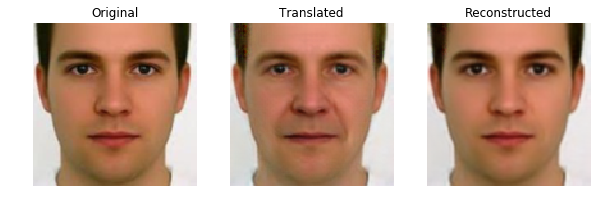

In [0]:
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 220,path="gdrive/My Drive/face4/models/combined_ep_221.h5")
cyclegan.test_k_images(im_path="gdrive/My Drive/faceage_inference/3.jpg",translated_path="gdrive/My Drive/face4/test_images/age_translated_image.jpg" ,output_path="gdrive/My Drive/face4/test_images/ageChange.jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


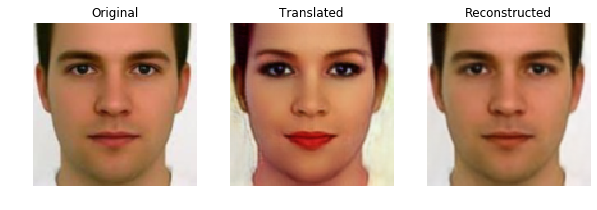

In [0]:
#Gender change model
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 220,path="gdrive/My Drive/gender_model/combined_ep_221.h5")
cyclegan.test_k_images(im_path="gdrive/My Drive/faceage_inference/3.jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


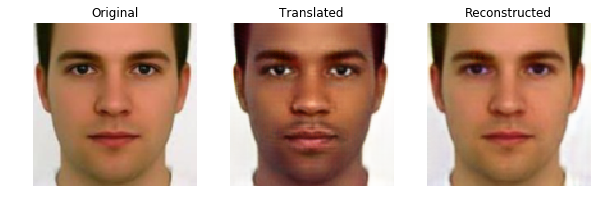

In [0]:
#Race change model
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 220,path="gdrive/My Drive/race_model/combined_ep_251.h5")
cyclegan.test_k_images(im_path="gdrive/My Drive/faceage_inference/3.jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


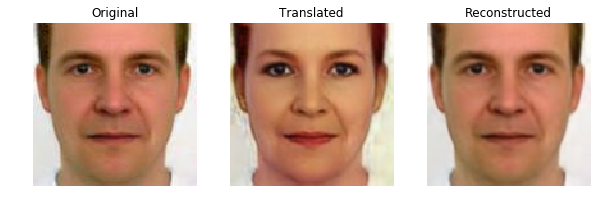

In [0]:
#Age to Gender change model
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 220,path="gdrive/My Drive/gender_model/combined_ep_221.h5")
cyclegan.test_k_images(im_path="gdrive/My Drive/face4/test_images/age_translated_image.jpg",translated_path="gdrive/My Drive/face4/test_images/gender_translated_image.jpg" ,output_path="gdrive/My Drive/face4/test_images/age_genderChange.jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


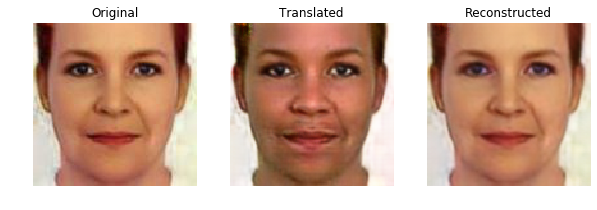

In [0]:
#Age to gender to race change model
cyclegan = CycleGAN()
cyclegan.load_network(n_epoch_start = 220,path="gdrive/My Drive/race_model/combined_ep_251.h5")
cyclegan.test_k_images(im_path="gdrive/My Drive/face4/test_images/gender_translated_image.jpg",translated_path="gdrive/My Drive/face4/test_images/age_gender_race_translated_image.jpg" ,output_path="gdrive/My Drive/face4/test_images/age_gender_raceChange.jpg")